In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
df = yf.download('TCS.NS', start="2023-01-01", period='1y', interval='1d')
df.reset_index(inplace=True)
df.columns = df.columns.get_level_values(0)
df

/tmp/ipython-input-3765627501.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('TCS.NS', start="2023-01-01", period='1y', interval='1d')
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
0,2023-01-02,2986.108887,2991.053137,2962.074988,2985.696922,709547
1,2023-01-03,3031.796143,3039.715795,2971.322234,2977.456555,1245178
2,2023-01-04,3034.817383,3046.445390,3008.769260,3027.538590,1231668
3,2023-01-05,3031.567383,3055.555458,3004.878177,3049.054771,1826057
4,2023-01-06,2940.422119,3022.824070,2929.847157,3021.404881,2488376
...,...,...,...,...,...,...
240,2023-12-22,3626.119385,3646.933491,3567.327700,3603.361313,2413058
241,2023-12-26,3599.141602,3635.601882,3594.020897,3622.184195,1285231
242,2023-12-27,3613.981445,3620.619216,3573.016966,3602.412806,1293976
243,2023-12-28,3603.265869,3639.394395,3595.869682,3626.118855,1682889


<Axes: xlabel='Date', ylabel='Close'>

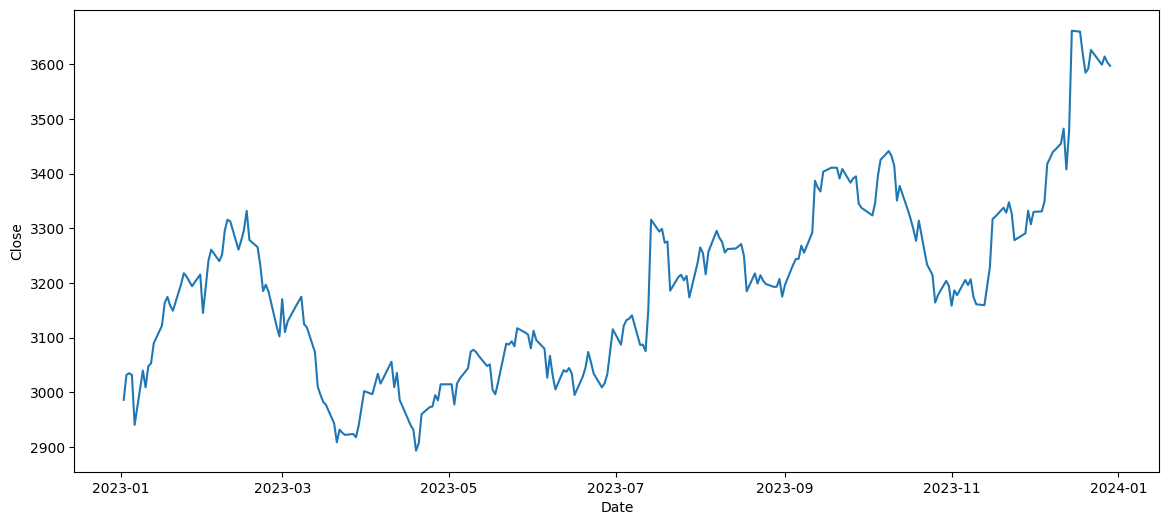

In [8]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='Date', y='Close')

## Volatility and Momentum

<Axes: xlabel='Date', ylabel='Close'>

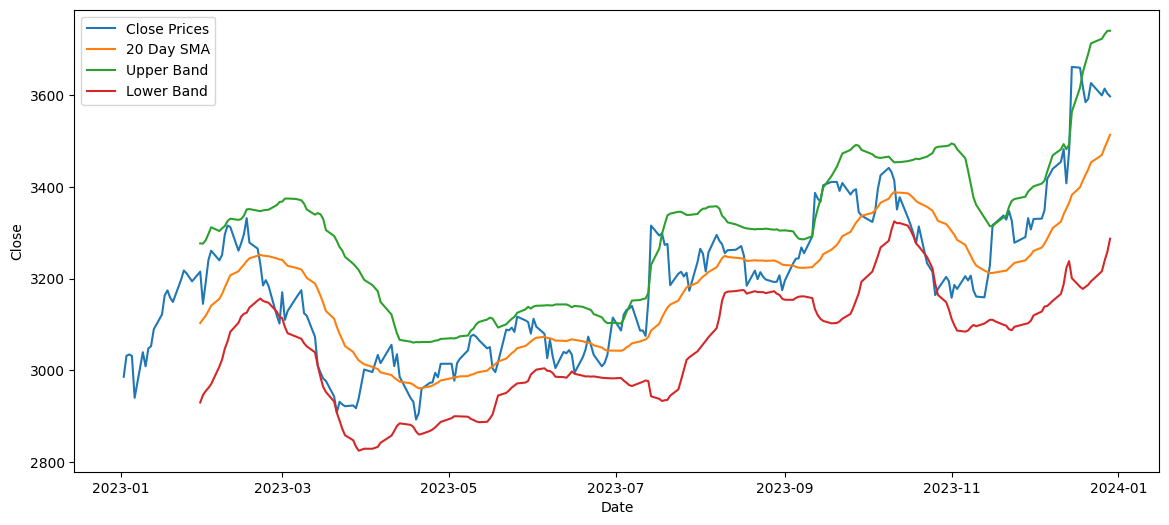

In [10]:
def bb(df):
  df["20 Day SMA"] = df["Close"].rolling(20).mean()
  df["std"] = df["Close"].rolling(20).std()
  df["Upper Band"] = df["20 Day SMA"] + 2*df["std"]
  df["Lower Band"] = df["20 Day SMA"] - 2*df["std"]
  return df

df = bb(df)
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='Date', y='Close', label="Close Prices")
sns.lineplot(data=df, x='Date', y='20 Day SMA', label="20 Day SMA")
sns.lineplot(data=df, x='Date', y='Upper Band', label="Upper Band")
sns.lineplot(data=df, x='Date', y='Lower Band', label="Lower Band")

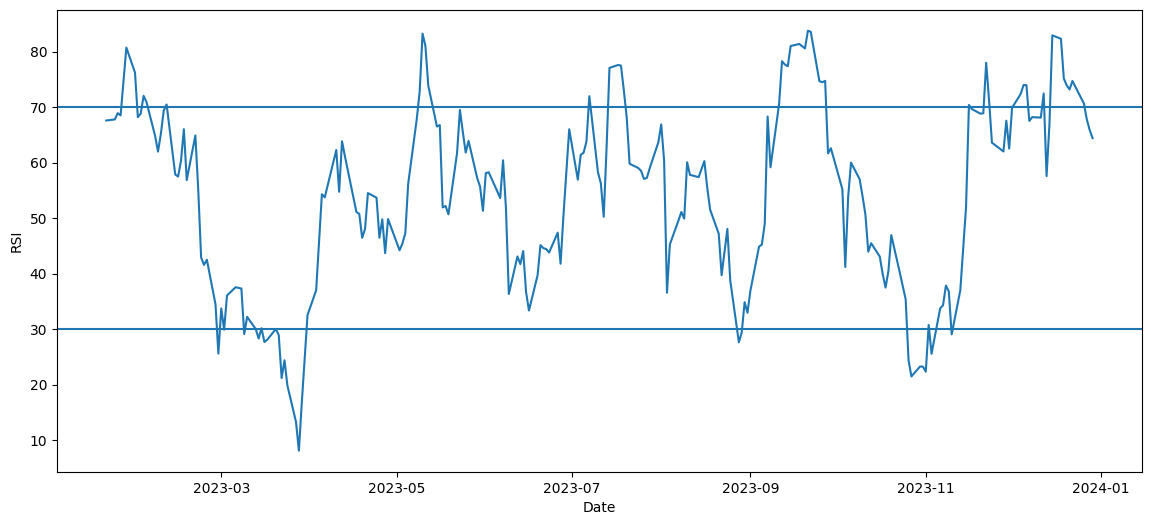

In [14]:
def rsi(df,period):
  df['diff'] = df['Close'].diff()
  df['Gain'] = (np.where(df['diff'] < 0, 0, df['diff']))
  df['Loss'] = abs(np.where(df['diff'] > 0, 0 , df['diff']))
  df['avg_gain'] = df['Gain'].rolling(period).mean()
  df['avg_loss'] = df['Loss'].rolling(period).mean()
  df['RS'] = df['avg_gain']/df['avg_loss']
  df['RSI'] = 100 - (100/(1+df['RS']))
  return df

df = rsi(df,14)
plt.figure(figsize=(14,6))
sns.lineplot(data=df, x='Date', y='RSI')
plt.axhline(y = 70)
plt.axhline(y = 30)
plt.show()

## Trend and Oscillators

<Axes: xlabel='Date', ylabel='MACD'>

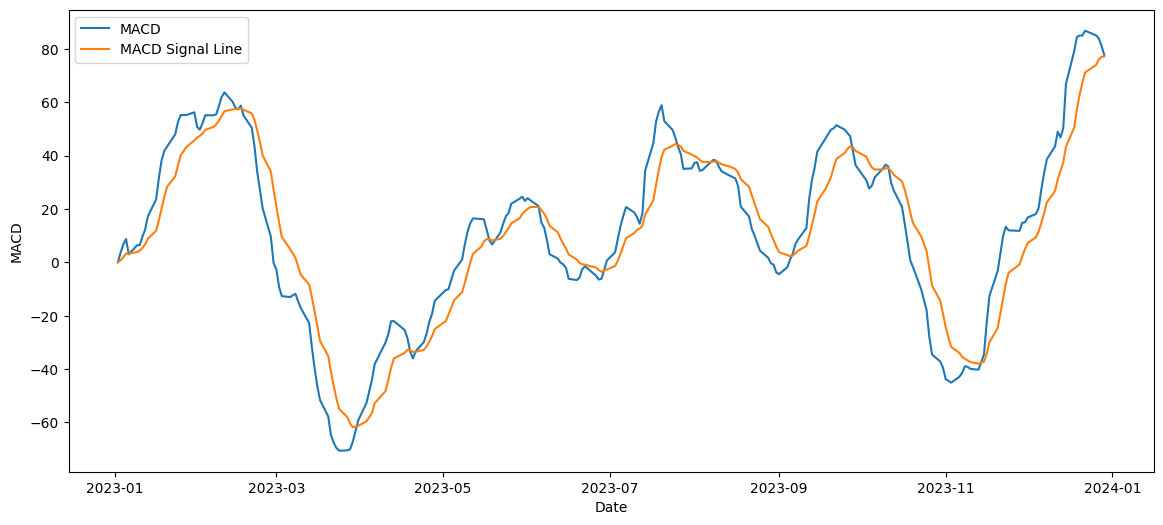

In [16]:
def macd(df):
  df["12 Day EMA"] = df["Close"].ewm(span=12, adjust=False).mean()
  df["26 Day EMA"] = df["Close"].ewm(span=26, adjust=False).mean()
  df['MACD'] = df['12 Day EMA'] - df['26 Day EMA']
  df['signal line'] = df['MACD'].ewm(span=9, adjust=False).mean()
  return df

df = macd(df)
plt.figure(figsize=(14,6))
sns.lineplot(data=df, x='Date', y='MACD', label="MACD")
sns.lineplot(data=df, x='Date', y='signal line', label="MACD Signal Line")

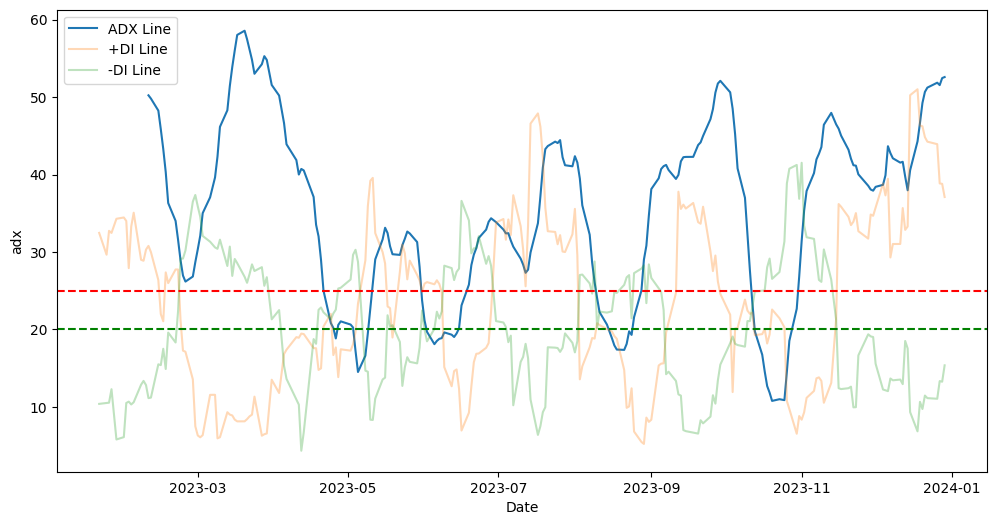

In [23]:
def adx(df):
  df['up'] = df['High'] - df['High'].shift(1)
  df['down'] = df['Low'].shift(1) - df['Low']

  df['+dm'] = np.where((df['up'] > df['down']) & (df['up'] > 0), df['up'], 0)
  df['-dm'] = np.where((df['down'] > df['up']) & (df['down'] > 0), df['down'], 0)

  df["tr"] = np.maximum.reduce([
        df['High'] - df['Low'],
        (df['High'] - df['Close'].shift(1)).abs(),
        (df['Low'] - df['Close'].shift(1)).abs()
    ])
  df["tr_smooth"] = df["tr"].rolling(14).sum()
  df["+dm_smooth"] = df["+dm"].rolling(14).sum()
  df["-dm_smooth"] = df["-dm"].rolling(14).sum()

  df["+di"] = 100 * (df["+dm_smooth"] / df["tr_smooth"])
  df["-di"] = 100 * (df["-dm_smooth"] / df["tr_smooth"])

  df['dx'] = 100* abs(df['+di'] - df['-di']) / (df['+di'] + df['-di'])
  df['adx'] = df['dx'].rolling(14).mean()
  return df

df = adx(df)
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='Date', y='adx', label='ADX Line')
sns.lineplot(data=df, x='Date', y='+di', label='+DI Line', alpha=0.3)
sns.lineplot(data=df, x='Date', y='-di', label='-DI Line', alpha=0.3)
plt.axhline(y = 25, color='r', linestyle='--')
plt.axhline(y = 20, color='g', linestyle='--')

## Price Action

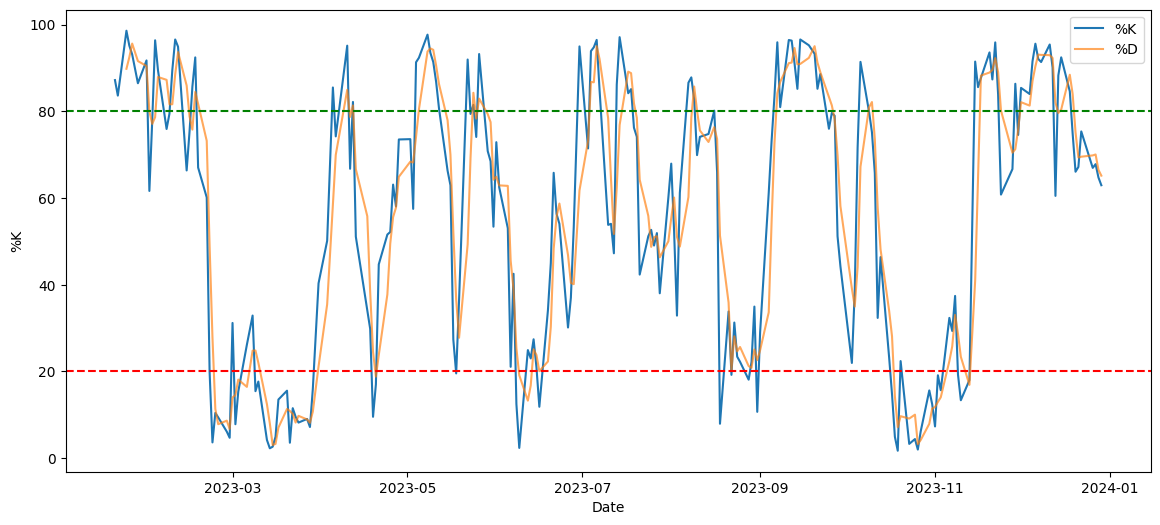

In [25]:
def so(df):
  df['Lowest_Low'] = df['Low'].rolling(14).min()
  df['Highest_High'] = df['High'].rolling(14).max()
  df['%K'] = (df['Close'] - df['Lowest_Low']) * 100 / (df['Highest_High'] - df['Lowest_Low'])
  df['%D'] = df['%K'].rolling(3).mean()
  return df

df = so(df)
plt.figure(figsize=(14,6))
sns.lineplot(data=df, x='Date', y='%K', label='%K')
sns.lineplot(data=df, x='Date', y='%D', label='%D', alpha=0.67)
plt.axhline(y = 20, color='r', linestyle='--')
plt.axhline(y = 80, color='g', linestyle='--')

<Axes: xlabel='Date', ylabel='tr_smooth'>

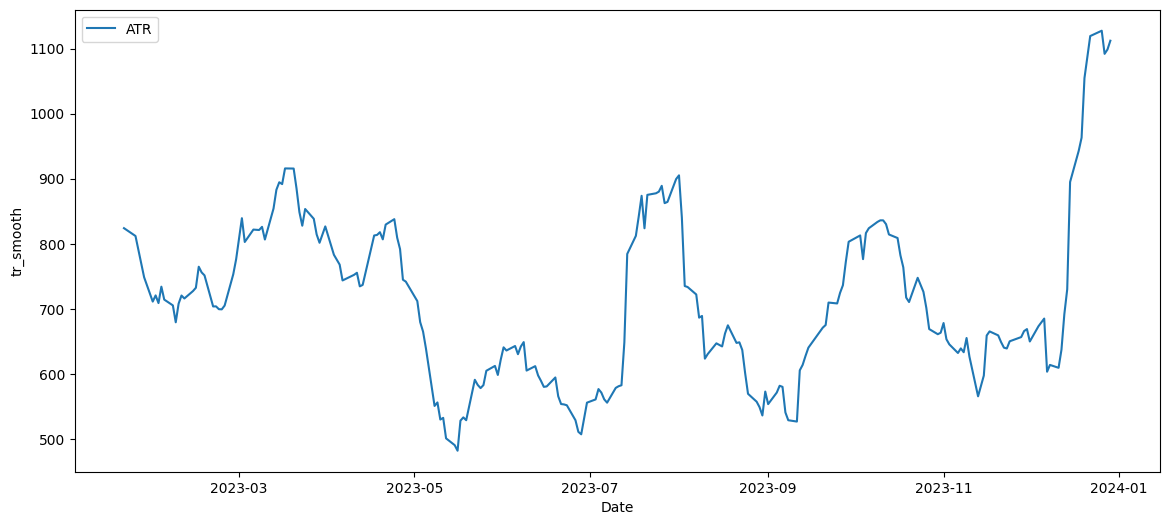

In [26]:
# average true range was already used in the average directional index so
plt.figure(figsize=(14,6))
sns.lineplot(data=df, x='Date', y='tr_smooth', label='ATR')

# Signals

In [31]:
def bb_signal(df):
  df['BB_Signal'] = np.where((df['Close']<df['Lower Band']), 'BUY', np.where((df['Close']>df['Upper Band']), 'SELL', 'HOLD'))
  return df
df = bb_signal(df)
df.loc[df['BB_Signal'] != 'HOLD']['BB_Signal'].value_counts()

,count
BB_Signal,
SELL,14
BUY,6


In [30]:
def rsi_signal(df):
  df['RSI_Signal'] = np.where((df['RSI']<30), 'BUY', np.where((df['RSI']>70), 'SELL', 'HOLD'))
  return df
df = rsi_signal(df)
df.loc[df['RSI_Signal'] != 'HOLD']['RSI_Signal'].value_counts()

,count
RSI_Signal,
SELL,40
BUY,22


In [32]:
def macd_signal(df):
  df['MACD_Signal'] = np.where((df['MACD']>df['signal line']), 'BUY', np.where((df['MACD']<df['signal line']), 'SELL', 'HOLD'))
  return df
df = macd_signal(df)
df.loc[df['MACD_Signal'] != 'HOLD']['MACD_Signal'].value_counts()

,count
MACD_Signal,
BUY,138
SELL,106


In [36]:
def adx_signal(df):
  df['ADX_Signal'] = np.where(((df['+di']>df['-di']) & (df['adx']>25)), 'BUY', np.where(((df['-di']>df['+di']) & (df['adx']>25)), 'SELL', 'HOLD'))
  return df

df = adx_signal(df)
df.loc[df['ADX_Signal'] != 'HOLD']['ADX_Signal'].value_counts()

,count
ADX_Signal,
BUY,105
SELL,65


In [38]:
def so_signal(df):
  df['SO_Signal'] = np.where(((df['%K']<20) & (df['%K']>df['%D'])), 'BUY', np.where(((df['%K']>80) & (df['%K']<df['%D'])), 'SELL', 'HOLD'))
  return df

df = so_signal(df)
df.loc[df['SO_Signal'] != 'HOLD']['SO_Signal'].value_counts()

,count
SO_Signal,
SELL,24
BUY,14


In [39]:
def atr_signal(df):
  df['atr_ma'] = df['tr_smooth'].rolling(14).mean()
  df['ATR_Signal'] = np.where(((df['tr_smooth']>df['atr_ma']) & (df['Close']>df['Close'].shift(1))), 'BUY', np.where(((df['tr_smooth']>df['atr_ma']) & (df['adx']>df['Close'].shift(1))), 'SELL', 'HOLD'))
  return df

df = atr_signal(df)
df.loc[df['ATR_Signal'] != 'HOLD']['ATR_Signal'].value_counts()

,count
ATR_Signal,
BUY,57
